In [1]:
from pandas import *
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import daniel_utils as du
import datetime
import math
import random
%load_ext autoreload
%autoreload 2


/home/daniel/miniconda3/lib/python3.5/site-packages/IPython/html.py:14: ShimWarning: The `IPython.html` package has been deprecated. You should import from `notebook` instead. `IPython.html.widgets` has moved to `ipywidgets`.
  "`IPython.html.widgets` has moved to `ipywidgets`.", ShimWarning)


In [2]:
cycle_id = 9 # should be renamed participant ID

df = read_csv(filepath_or_buffer="csv/london.csv", header=0)

df = du.zero_to_nan(df)

#df = df.dropna(subset={'L_PREOV', 'L_PERIOD'})

df = du.rename_it_en(df)
df = df.reset_index(drop=True)

# choose a random array element from the array of unique ID values
cycle_id = random.choice(df.ID.unique())


In [3]:
df = df[df['ID'] == cycle_id]
df = df.reset_index(drop=True)

for i in range(0, len(df)):
    #print(str(df['BEGIN_DATE'][i])[-2:])
    df['BEGIN_DATE'][i] = str(df['BEGIN_DATE'][i])[:-2] + "19" + str(df['BEGIN_DATE'][i])[-2:]



df['BEGIN_DATE'] = pd.to_datetime(df['BEGIN_DATE'], format='%d-%m-%Y')
df.to_csv('london_datetime.csv')

/home/daniel/miniconda3/lib/python3.5/site-packages/ipykernel/__main__.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [4]:
curr_id = df['ID'][0]
# n_cycles = df['N_CYCLES'][0] # doesn't work if some cycles were dropped due to df.dropna

df_subject = pd.DataFrame(columns=['day', 'BBT'])

for x in range(0, len(df['BEGIN_DATE'])):

    df_cycle = du.get_cycle_with_bbt(df, x)
    
    # iterate through df_cycle, converting the day to the date on which the BBT was observed
    for i in range(0, len(df_cycle)):
        
        df_cycle['day'][i] = (df['BEGIN_DATE'][x] + datetime.timedelta(days = i))

   
    frames = [df_subject, df_cycle]
    df_subject = pd.concat(frames, ignore_index=True)


/home/daniel/miniconda3/lib/python3.5/site-packages/ipykernel/__main__.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [5]:
# replace discontinuities with NaN

total_days = df_subject['day'][len(df_subject)-1] - df_subject['day'][0]



for x in range(1, total_days.days):
    curr_date = df_subject['day'][x-1]
    prev_date = df_subject['day'][x]
    if(curr_date  + datetime.timedelta(days=1) != prev_date): # if one day after yesterday (curr_date + 1 day) isn't equal to today (prev_date), there must be a discontinuity
        # insert a NaN in between
        line = DataFrame({"day": curr_date + datetime.timedelta(days=1), "BBT": np.nan}, index=[x])
        df_subject = concat([df_subject.ix[:x-1], line, df_subject.ix[x:]]).reset_index(drop=True)
        
df_subject.to_csv('csv/temp.csv')

<IPython.core.display.Javascript object>


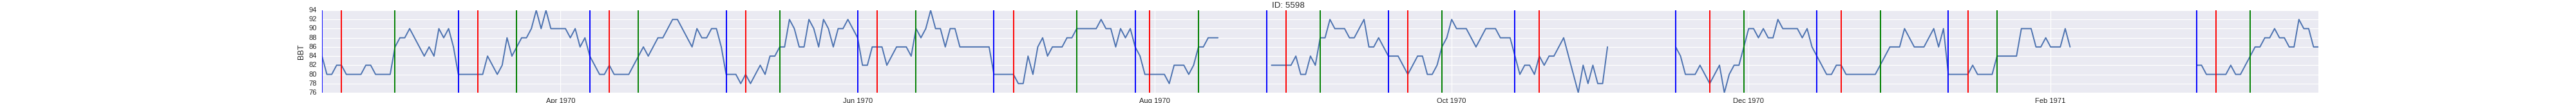

ID: 5598


In [6]:
%matplotlib nbagg
#%matplotlib inline
fig = plt.figure(figsize=(50, 2))
fig.suptitle('ID: ' + str(cycle_id))
ax = fig.add_subplot(111)
ax.set_xlabel('Date')
ax.set_ylabel('BBT')
plt.plot(df_subject['day'], df_subject['BBT'])
for index, row in df.iterrows():
    if not math.isnan(row['L_PERIOD']):
        plt.axvline(row['BEGIN_DATE'] + datetime.timedelta(days = row['L_PERIOD']), color='red')
    if not math.isnan(row['L_PREOVULATION']):
        plt.axvline(row['BEGIN_DATE'] + datetime.timedelta(days = row['L_PREOVULATION']), color='green')

    plt.axvline(row['BEGIN_DATE'], color='blue')
#plt.scatter(df_subject['day'], df_subject['BBT'])
print("ID: " + str(cycle_id))
plt.show()